**check current model prediction**

In [1]:
# import sys
# from YoloSamPipeline import YoloSam

In [2]:
# yolo_path = './yolov8-segm-ft_no_stars-n/rtdetr-l/weights/last.pt' 

# yolo_sam_pipe = YoloSam(
#     device='cuda:0', 
#     yolo_checkpoint=yolo_path, 
#     sam_checkpoint='./output_sam/ft_mobile_sam_final.pth', # the checkpoint and model_type should be compatible
#     model_type='vit_t')

In [3]:
# yolo_sam_pipe.run_predict('../XMM_OM_dataset/zscaled_512_stretched/S0412991401_U.png') 

In [4]:
# yolo_sam_pipe.run_predict('../XMM_OM_dataset/zscaled_512_stretched/S0412991401_U.png') 

# Import the YOLOv8 pretrained model

- The model is pretrained (in another notebook)  using a Roboflow dataset version on OM images. 

In [5]:
from ultralytics import YOLO
from matplotlib import pyplot as plt
from PIL import Image
PYTORCH_NO_CUDA_MEMORY_CACHING=1

from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import torch
from torch import cuda
import os
import numpy as np
import random
from PIL import Image
import matplotlib.colors as mcolors
import numpy.ma as ma
import json
np.set_printoptions(precision=15)

torch.backends.cudnn.deterministic = True
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from typing import Any, Dict, Generator, List
import matplotlib.pyplot as plt
import numpy as np

from dataset import dataset_utils
from sam_predictor import predictor_utils
from losses import loss
from yolo_predictor import yolo_predictor_utils

import torch.autograd.profiler as profiler
device_id = 2
torch.cuda.set_device(device_id) # ❗️❗️❗️

In [6]:
use_wandb = False

if use_wandb:
    from datetime import datetime
    # !pip install wandb
    # !wandb login --relogin
    import wandb
    wandb.login()
    run = wandb.init(project="yolo-sam", name=f"yolo-sam {datetime.now()}")

## Dataset (YOLOv8 format)

In [7]:
yolo_dataset_path = './roboflow_datasets/xmm_om_artefacts_512-21-YOLO/'

In [8]:
import yaml
with open(yolo_dataset_path+"data.yaml", 'r') as stream:
    yam_data = yaml.safe_load(stream) # dict with keys 'names', 'nc', 'roboflow', 'test', 'train', 'val'
yam_data['names']

classes = {i:name for i, name in enumerate(yam_data['names'])}
train_path = yam_data['train']
val_path = yam_data['val']
print(classes)

{0: 'central-ring', 1: 'smoke-ring', 2: 'star-loop'}


In [9]:
# # get masks from dataset (in YOLOv8 format) given an image file

# def get_label_file_path(dataset_path, image_location):
#     dataset_path = '/'.join(dataset_path.split('/')[:-2])+'/'+'labels'+'/'
#     label_file_path = os.path.join(dataset_path, image_location)
#     label_loc = '.'.join(image_location.split('.')[:-1]) + '.txt'
#     label_file_path = dataset_path+label_loc
#     return label_file_path

# def read_annotations(label_file_path):
#     annotations = []
#     k = 0
#     with open(label_file_path, 'r') as file:
#         for line in file:
#             print(k+1)
#             k+=1
#             parts = line.strip().split()
#             class_id = int(parts[0])
#             segmentation_points = [float(p) for p in parts[1:]]
#             annotations.append({
#                 'class_id': class_id,
#                 'segmentation_points': segmentation_points
#             })
#     return annotations

# def get_masks_from_image(yolo_dataset_path, image_location):
#     label_file_path = get_label_file_path(yolo_dataset_path, image_location)
#     annotations = read_annotations(label_file_path)
#     masks = [dataset_utils.create_mask_0_1(annot['segmentation_points'], (512, 512)) for annot in annotations]
#     return masks

# def get_classes_from_image(yolo_dataset_path, image_location):
#     label_file_path = get_label_file_path(yolo_dataset_path, image_location)
#     annotations = read_annotations(label_file_path)
#     class_ids = [annot['class_id'] for annot in annotations]
#     return class_ids

**hyperparameters docs: https://docs.ultralytics.com/usage/cfg/#train**

In [10]:
# def show_masks(masks, ax, random_color=False):
#     for mask in masks:
#         if random_color:
#             color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
#         else:
#                 color = np.array([30/255, 144/255, 255/255, 0.6])
#         h, w = mask.shape[-2:]
#         mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
#         ax.imshow(mask_image)

# Couple YOLO bboxes with SAM

In [11]:
# def show_anns(anns):
#     if len(anns) == 0:
#         return
#     ax = plt.gca()
#     ax.set_autoscale_on(False)
#     img = np.ones((anns.shape[1], anns.shape[2], 4))
#     img[:,:,3] = 0
#     for ann in range(anns.shape[0]):
#         m = anns[ann].bool()
#         m=m.cpu().numpy()
#         color_mask = np.concatenate([np.random.random(3), [1]])
#         img[m] = color_mask
#     ax.imshow(img)

# def batch_iterator(batch_size: int, *args) -> Generator[List[Any], None, None]:
#     assert len(args) > 0 and all(
#         len(a) == len(args[0]) for a in args
#     ), "Batched iteration must have inputs of all the same size."
#     n_batches = len(args[0]) // batch_size + int(len(args[0]) % batch_size != 0)
#     for b in range(n_batches):
#         yield [arg[b * batch_size : (b + 1) * batch_size] for arg in args]

**load SAM model**

In [12]:
import sys
import PIL
from PIL import Image

sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/')
from ft_mobile_sam import sam_model_registry, SamPredictor

# mobile_sam_checkpoint = "/workspace/raid/OM_DeepLearning/Mobil_eSAM-fine-tuning/weights/mobile_sam.pt"
mobile_sam_checkpoint = "./output_sam/ft_mobile_sam_final.pth"

yolov8_pretrained_model = YOLO('./yolov8-segm-ft_no_stars-n/yolov8n-seg2/weights/best.pt');
yolov8_pretrained_model.to(f'cuda:{device_id}');

device = f"cuda:{device_id}" if torch.cuda.is_available() else "cpu"
print("device:", device)

mobile_sam_model = sam_model_registry["vit_t"](checkpoint=mobile_sam_checkpoint)
mobile_sam_model.to(device)
predictor = SamPredictor(mobile_sam_model)

/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_5m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_11m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/ft_mobile_sam/modeling/tiny_vit_sam.py:656: UserWarning: Overwriting tiny_vit_21m_224 in registry with ft_mobile_sam.modeling.tiny_vit_sam.tiny_vit_21m_224. This is because the name being registered conflicts with an existing na

device: cuda:2


In [13]:
train_dir = yolo_dataset_path+'train/images/'
valid_dir = yolo_dataset_path+'valid/images/'
train_image_files = os.listdir(train_dir)
valid_image_files = os.listdir(valid_dir)

In [14]:
for name, param in mobile_sam_model.named_parameters():
    params_to_train = ['mask_tokens', 'output_upscaling', 'output_hypernetworks_mlps', 'iou_prediction_head']
    # if 'mask_decoder' in name: # and any(s in name for s in params_to_train):
    if True:
        param.requires_grad = False
    else:
        param.requires_grad = False

In [15]:
# def check_requires_grad(model, show=True):
#     for name, param in model.named_parameters():
#         if param.requires_grad and show:
#             print("✅ Param", name, " requires grad.")
#         elif param.requires_grad == False:
#             print("❌ Param", name, " doesn't require grad.")

print(f"🚀 The model has {sum(p.numel() for p in mobile_sam_model.parameters() if p.requires_grad)} trainable parameters.\n")
check_requires_grad(mobile_sam_model)

🚀 The model has 0 trainable parameters.

❌ Param image_encoder.patch_embed.seq.0.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.0.bn.bias  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.c.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.weight  doesn't require grad.
❌ Param image_encoder.patch_embed.seq.2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv1.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.c.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.weight  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv2.bn.bias  doesn't require grad.
❌ Param image_encoder.layers.0.blocks.0.conv3.c.weight  doe

In [16]:
import time
import torch.nn.functional as F

import tqdm
from tqdm import tqdm

batch_size = 12
train_num_batches = len(train_image_files) // batch_size
valid_num_batches = len(valid_image_files) // batch_size

lr=6e-5
wd=0.0005
parameters_to_optimize = [param for param in mobile_sam_model.mask_decoder.parameters() if param.requires_grad]
# optimizer = torch.optim.Adam(parameters_to_optimize, lr=lr, weight_decay=wd) #betas=(0.9, 0.999))

In [17]:
from torch.nn.functional import threshold, normalize

def run_epoch(phase, image_files, images_dir, num_batches, model_, optimizer=None, train_encoders=False):
    assert phase in ['train', 'val'], "Phase must be 'train' or 'val'"
    
    if phase == 'train':
        model_.train()  
    else:
        model_.eval() 

    epoch_sam_loss = []
    epoch_yolo_loss = []
    all_preds, all_gts, all_pred_cls, all_gt_cls, all_iou_scores = [], [], [], [], []
    for batch_idx in tqdm(range(num_batches), desc=f'{phase[0].upper()+phase[1:]} Progress', bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size
        batch_files = image_files[start_idx:end_idx]

        batch_losses_sam = []
        batch_losses_yolo = []

        for image_name in batch_files:
            image_path = images_dir + image_name
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            obj_results = yolov8_pretrained_model.predict(image_path, verbose=False, conf=0.2) 
            predictor.set_image(image)
            # sets a specific mean for each image
            image_T = np.transpose(image, (2, 1, 0))
            mean_ = np.mean(image_T[image_T>0])
            std_ = np.std(image_T[image_T>0]) 
            pixel_mean = torch.as_tensor([mean_, mean_, mean_], dtype=torch.float, device=device)
            pixel_std = torch.as_tensor([std_, std_, std_], dtype=torch.float, device=device)
    
            mobile_sam_model.register_buffer("pixel_mean", torch.Tensor(pixel_mean).unsqueeze(-1).unsqueeze(-1), False) # not in SAM
            mobile_sam_model.register_buffer("pixel_std", torch.Tensor(pixel_std).unsqueeze(-1).unsqueeze(-1), False) # not in SAM
                
            gt_masks = yolo_predictor_utils.get_masks_from_image(images_dir, image_name) 
            gt_classes = yolo_predictor_utils.get_classes_from_image(images_dir, image_name) 
            if len(obj_results[0]) == 0 or len(gt_masks) == 0:
                continue
                
            input_boxes1 = obj_results[0].boxes.xyxy
            expand_by = 1.0
            enlarged_bbox = input_boxes1.clone() 
            enlarged_bbox[:, :2] -= expand_by  
            enlarged_bbox[:, 2:] += expand_by  
            input_boxes1 = enlarged_bbox
            input_boxes = input_boxes1.cpu().numpy()
            input_boxes = predictor.transform.apply_boxes(input_boxes, predictor.original_size)
            input_boxes = torch.from_numpy(input_boxes).to(device)
            sam_mask, yolo_masks = [], []
            
            if train_encoders:
                image_embedding=predictor.features
                prompt_embedding=model_.prompt_encoder.get_dense_pe()
            else:
                with torch.no_grad():
                    image_embedding=predictor.features
                    prompt_embedding=model_.prompt_encoder.get_dense_pe()
                
            non_resized_masks = obj_results[0].masks.data.cpu().numpy()
            
            for i in range(len(non_resized_masks)):
                    yolo_masks.append(cv2.resize(non_resized_masks[i], image.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)) 

            for (boxes,) in yolo_predictor_utils.batch_iterator(100, input_boxes): 
                sparse_embeddings, dense_embeddings = model_.prompt_encoder(
                            points=None,
                            boxes=boxes,
                            masks=None,)
                
                if phase == 'val':
                    with torch.no_grad():
                        low_res_masks, iou_predictions = mobile_sam_model.mask_decoder(
    								image_embeddings=image_embedding,
    								image_pe=prompt_embedding,
    								sparse_prompt_embeddings=sparse_embeddings,
    								dense_prompt_embeddings=dense_embeddings,
    								multimask_output=True,
    							)
                else:
                    low_res_masks, iou_predictions = mobile_sam_model.mask_decoder(
								image_embeddings=image_embedding,
								image_pe=prompt_embedding,
								sparse_prompt_embeddings=sparse_embeddings,
								dense_prompt_embeddings=dense_embeddings,
								multimask_output=True,
							)
                    
                max_low_res_masks = torch.zeros((low_res_masks.shape[0], 1, 256, 256))
                max_ious = torch.zeros((iou_predictions.shape[0], 1))
        
                # Take all low_res_mask correspnding to the index of max_iou
                for i in range(low_res_masks.shape[0]):
                    max_iou_index = torch.argmax(iou_predictions[i])
                    max_low_res_masks[i] = low_res_masks[i][max_iou_index].unsqueeze(0)
                    max_ious[i] = iou_predictions[i][max_iou_index]
                    
                low_res_masks = max_low_res_masks
                iou_predictions = max_ious
                print('Iou predicitons:', iou_predictions)
                print('Number of object detected per image:', len(iou_predictions))
                
                low_res_masks=predictor.model.postprocess_masks(
                   low_res_masks, 
                   predictor.input_size, 
                   predictor.original_size).to(device)
            
                # Apply Gaussian filter on logits
                kernel_size, sigma = 5, 2
                gaussian_kernel = predictor_utils.create_gaussian_kernel(kernel_size, sigma).to(device)
                pred_masks = torch.nn.functional.conv2d(low_res_masks, gaussian_kernel, padding=kernel_size//2)
                threshold_masks = torch.sigmoid(10 * (pred_masks - mobile_sam_model.mask_threshold)) # sigmoid with steepness
                sam_mask_pre = (threshold_masks > 0.5)*1.0
                sam_mask.append(sam_mask_pre.squeeze(1))

                # print('pred', obj_results[0].boxes.cls.detach().cpu().numpy())
                # print('pred masks', threshold_masks.shape)
                
                # reshape gt_masks to same shape as predicted masks
                gt_masks_tensor = torch.stack([torch.from_numpy(mask).unsqueeze(0) for mask in gt_masks], dim=0).to(device)
                yolo_masks_tensor = torch.stack([torch.from_numpy(mask).unsqueeze(0) for mask in yolo_masks], dim=0).to(device)
                segm_loss_yolo, preds, gts, gt_classes_match, pred_classes_match, ious_match = loss.segm_loss_match_hungarian(threshold_masks, threshold_masks, gt_masks_tensor, 
                                                                                  obj_results[0].boxes.cls.detach().cpu().numpy(), gt_classes, iou_predictions)
                segm_loss_sam, _, _2, _3, _4, _5  = loss.segm_loss_match_hungarian(yolo_masks_tensor, yolo_masks_tensor, gt_masks_tensor, 
                                                                                  obj_results[0].boxes.cls.detach().cpu().numpy(), gt_classes, iou_predictions)
                all_preds.append(preds)
                all_gts.append(gts)
                all_gt_cls.append(gt_classes_match)
                all_pred_cls.append(pred_classes_match)
                all_iou_scores.append(ious_match)
                
                batch_losses_sam.append(segm_loss_sam)
                batch_losses_yolo.append(segm_loss_yolo)
                del sparse_embeddings, dense_embeddings, low_res_masks, gt_masks, 
                del yolo_masks_tensor, segm_loss_sam, segm_loss_yolo
                torch.cuda.empty_cache()

                # if phase == 'val':
                #     fig, axes = plt.subplots(1, 4, figsize=(18, 6)) 
                    
                #     # Plot 1: GT Masks
                #     axes[0].imshow(image)
                #     axes[0].set_title('GT Masks')
                #     show_masks(gt_masks_tensor.squeeze(1).squeeze(1).detach().cpu().numpy(), axes[0], random_color=True)
                    
                #     # Plot 2: YOLO Masks
                #     axes[1].imshow(image)
                #     axes[1].set_title('YOLOv8n predicted Masks')
                #     show_masks(yolo_masks, axes[1], random_color=True)
                    
                #     # Plot 3: Bounding Boxes
                #     image1 = cv2.resize(image, (1024, 1024))
                #     for bbox in boxes:
                #         x1, y1, x2, y2 = bbox.detach().cpu().numpy()
                #         x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                #         cv2.rectangle(image1, (x1, y1), (x2, y2), (0, 255, 0), 2) 
                #     image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
                #     axes[2].imshow(image1_rgb)
                #     axes[2].set_title('YOLOv8n predicted Bboxes')
                    
                #     # Plot 4: SAM Masks
                #     sam_masks_numpy = sam_mask[0].detach().cpu().numpy()
                #     axes[3].imshow(image)
                #     show_masks(sam_masks_numpy, axes[3], random_color=True)
                #     axes[3].set_title('MobileSAM predicted masks')
                #     plt.tight_layout() 
                #     # plt.savefig(f'./plots/combined_plots.png')
                #     plt.show()

        mean_loss_sam = torch.mean(torch.stack(batch_losses_sam)) * 1e5
        mean_loss_yolo = torch.mean(torch.stack(batch_losses_yolo))
        epoch_sam_loss.append(mean_loss_sam.item()/1e5)
        epoch_yolo_loss.append(mean_loss_yolo.item())
        print('all_gt_cls', all_gt_cls)
        print('all_pred_cls', all_pred_cls)
        
        if phase == 'train':
            optimizer.zero_grad()
            mean_loss_sam.backward()
            optimizer.step()

    # print(f'Epoch {epoch}, {phase.capitalize()} Segmentation loss SAM: {np.mean(epoch_sam_loss)}. YOLO: {np.mean(epoch_yolo_loss)}')
    return np.mean(epoch_sam_loss), np.mean(epoch_yolo_loss), model_, all_preds, all_gts, all_gt_cls, all_pred_cls, all_iou_scores

In [19]:
# best_valid_loss = float('inf')
# num_epochs = 15
# n_epochs_stop = 5 + num_epochs//10
# epoch_sam_loss_train_list, epoch_sam_loss_val_list, epoch_yolo_loss_train_list, epoch_yolo_loss_val_list = [], [], [], []

# model = mobile_sam_model
# for epoch in range(num_epochs):
#     epoch_sam_loss_train, epoch_yolo_loss_train, model = run_epoch('train', train_image_files, train_dir, train_num_batches, model, optimizer, train_encoders=True)
#     epoch_sam_loss_val, epoch_yolo_loss_val, model = run_epoch('val', valid_image_files, valid_dir, valid_num_batches, model)

#     epoch_sam_loss_train_list.append(epoch_sam_loss_train)
#     epoch_sam_loss_val_list.append(epoch_sam_loss_val)
#     epoch_yolo_loss_train_list.append(epoch_yolo_loss_train)
#     epoch_yolo_loss_val_list.append(epoch_yolo_loss_val)
    
#     if use_wandb:
#         wandb.log({'epoch train SAM loss': epoch_sam_loss_train, 'epoch valid SAM loss': epoch_sam_loss_val})
#         wandb.log({'epoch train YOLO loss': epoch_yolo_loss_train, 'epoch valid YOLO loss': epoch_yolo_loss_val})

#     if epoch_sam_loss_val < best_valid_loss:
#         best_valid_loss = epoch_sam_loss_val
#         best_model = model
#         epochs_no_improve = 0
#     else:
#         epochs_no_improve += 1
#         if epochs_no_improve == n_epochs_stop:
#             print("Early stopping initiated.")
#             early_stop = True
#             break

# torch.save(best_model.state_dict(), f'yolo_sam_final.pth')
# if use_wandb:
#     run.finish()

In [20]:
# plt.plot(list(range(len(epoch_sam_loss_train_list))), epoch_sam_loss_train_list)
# plt.plot(list(range(len(epoch_sam_loss_val_list))), epoch_sam_loss_val_list)
# # plt.plot(list(range(len(epoch_yolo_loss_train_list))), epoch_yolo_loss_train_list)
# # plt.plot(list(range(len(epoch_yolo_loss_val_list))), epoch_yolo_loss_val_list)

# plt.title('Mean epoch loss \n YOLO-SAM')
# plt.xlabel('Epoch Number')
# plt.ylabel('Loss')
# plt.savefig('loss_yolo_SAM.png')
# plt.show()
# plt.close()

## Compute mean average precision

In [21]:
epoch_sam_loss_val, epoch_yolo_loss_val, model, preds, gts, gt_classes, pred_classes, all_iou_scores = run_epoch(
    'val', 
    valid_image_files, 
    valid_dir, 
    valid_num_batches, 
    mobile_sam_model)

Val Progress:   0%|          | 0/23 [00:00<?, ?it/s]                                                                                                                                                        

1
2
1
2
Iou predicitons: tensor([[0.8946],
        [0.8480]])
Number of object detected per image: 2
1
2
3
4
5
6
7
1
2
3
4
5
6
7
Iou predicitons: tensor([[0.9076],
        [0.8937]])
Number of object detected per image: 2
1
2
3
1
2
3
Iou predicitons: tensor([[0.8990]])
Number of object detected per image: 1
1
2
3
4
1
2
3
4
Iou predicitons: tensor([[0.9077],
        [0.7651],
        [0.7861],
        [0.7673]])
Number of object detected per image: 4
1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
Iou predicitons: tensor([[0.8523],
        [0.7748],
        [0.8478],
        [0.8299],
        [0.9059],
        [0.7831],
        [0.8761],
        [0.8172],
        [0.7644],
        [0.8149]])
Number of object detected per image: 10
1
2
3
4
5
6
7
8
9
10
11
12
1
2
3
4
5
6
7
8
9
10
11
12
Iou predicitons: tensor([[0.8851],
        [0.9148],
        [0.8273],
        [0.7645],
        [0.8166],
        [0.9018],
        [0.6804],
        [0.8173],
        [0.7510],
        [0.7441],
        [0.9051],
       

Val Progress:   4%|▍         | 1/23 [00:02<01:03,  2.89s/it]                                                                                                                                                

1
1
Iou predicitons: tensor([[0.8775]])
Number of object detected per image: 1
1
2
1
2
Iou predicitons: tensor([[0.7358],
        [0.8175]])
Number of object detected per image: 2
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0]]
all_pred_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 1], [1, 2, 1, 0, 2, 2, 2, 2, 1], [0], [1, 0]]
1
1
Iou predicitons: tensor([[0.8973]])
Number of object detected per image: 1
1
2
3
4
5
1
2
3
4
5
Iou predicitons: tensor([[0.8697],
        [0.9003],
        [0.8278],
        [0.8495],
        [0.8584]])
Number of object detected per image: 5
1
2
1
2
Iou predicitons: tensor([[0.9022],
        [0.8837]])
Number of object detected per image: 2
1
1
Iou predicitons: tensor([[0.8861]])
Number of object detected per

Val Progress:   9%|▊         | 2/23 [00:04<00:42,  2.02s/it]                                                                                                                                                

all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2]]
all_pred_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 1], [1, 2, 1, 0, 2, 2, 2, 2, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 1], [2, 2, 2]]
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
Iou predicitons: tensor([[0.9297],
        [0.8516],
        [0.8881],
        [0.8622],
        [0.7849],
   

Val Progress:  13%|█▎        | 3/23 [00:05<00:33,  1.67s/it]                                                                                                                                                

1
2
3
4
5
6
7
1
2
3
4
5
6
7
Iou predicitons: tensor([[0.8818],
        [0.8892],
        [0.8562],
        [0.8358],
        [0.8743],
        [0.7044],
        [0.8450]])
Number of object detected per image: 7
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2]]
all_pred_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 1], [1, 2, 1, 0, 2, 

Val Progress:  17%|█▋        | 4/23 [00:07<00:30,  1.58s/it]                                                                                                                                                

all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0]]
all_pred_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 1], [1, 2, 1, 0, 

Val Progress:  22%|██▏       | 5/23 [00:08<00:26,  1.44s/it]                                                                                                                                                

1
2
3
1
2
3
Iou predicitons: tensor([[0.9267],
        [0.9000],
        [0.8743]])
Number of object detected per image: 3
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0], [1, 0], [0, 1, 2], [0, 1, 2], [0, 2], [2, 0], [0], 

Val Progress:  26%|██▌       | 6/23 [00:09<00:23,  1.40s/it]                                                                                                                                                

1
2
3
4
5
6
7
1
2
3
4
5
6
7
Iou predicitons: tensor([[0.8794],
        [0.8500],
        [0.8793],
        [0.7378],
        [0.7814],
        [0.6057]])
Number of object detected per image: 6
1
2
1
2
Iou predicitons: tensor([[0.8394],
        [0.8366],
        [0.8314]])
Number of object detected per image: 3
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], 

Val Progress:  30%|███       | 7/23 [00:11<00:23,  1.50s/it]                                                                                                                                                

1
2
3
4
5
6
7
1
2
3
4
5
6
7
Iou predicitons: tensor([[0.9151],
        [0.9059],
        [0.8465],
        [0.8703],
        [0.8354],
        [0.5656],
        [0.6381]])
Number of object detected per image: 7
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 

Val Progress:  35%|███▍      | 8/23 [00:12<00:21,  1.46s/it]                                                                                                                                                

1
2
3
4
1
2
3
4
Iou predicitons: tensor([[0.9003],
        [0.8843],
        [0.8653]])
Number of object detected per image: 3
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0], [1, 0], [0, 1, 2], [0, 1, 2], [0, 2], [2, 0], [

Val Progress:  39%|███▉      | 9/23 [00:14<00:21,  1.50s/it]                                                                                                                                                

Iou predicitons: tensor([[0.8828],
        [0.8803]])
Number of object detected per image: 2
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0], [1, 0], [0, 1, 2], [0, 1, 2], [0, 2], [2, 0], [0], [0, 1, 1], [2, 1, 1, 2, 1, 1, 

Val Progress:  43%|████▎     | 10/23 [00:15<00:19,  1.52s/it]                                                                                                                                               

Iou predicitons: tensor([[0.9454],
        [0.8580],
        [0.8179],
        [0.8557],
        [0.8018],
        [0.9002],
        [0.8144],
        [0.8168],
        [0.8777],
        [0.6230],
        [0.7890],
        [0.9036],
        [0.7797],
        [0.8222]])
Number of object detected per image: 14
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2

Val Progress:  48%|████▊     | 11/23 [00:17<00:17,  1.44s/it]                                                                                                                                               

1
1
1
2
3
4
5
6
7
8
9
10
11
1
2
3
4
5
6
7
8
9
10
11
Iou predicitons: tensor([[0.8416],
        [0.8114],
        [0.8607],
        [0.6866],
        [0.7739],
        [0.8170],
        [0.8623],
        [0.7267],
        [0.7816],
        [0.8042],
        [0.8264],
        [0.5501]])
Number of object detected per image: 12
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 

Val Progress:  52%|█████▏    | 12/23 [00:18<00:15,  1.45s/it]                                                                                                                                               

1
2
1
2
Iou predicitons: tensor([[0.9048],
        [0.7825]])
Number of object detected per image: 2
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0], [1, 0], [0, 1, 2], [0, 1, 2], [0, 2], [2, 0], [0], [0, 1, 1], [2, 1, 1, 2

Val Progress:  57%|█████▋    | 13/23 [00:19<00:13,  1.39s/it]                                                                                                                                               

1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
Iou predicitons: tensor([[0.9005],
        [0.8705],
        [0.8228],
        [0.8266],
        [0.7162],
        [0.8203]])
Number of object detected per image: 6
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1,

Val Progress:  61%|██████    | 14/23 [00:21<00:12,  1.40s/it]                                                                                                                                               

1
2
3
4
5
6
7
8
1
2
3
4
5
6
7
8
Iou predicitons: tensor([[0.8808],
        [0.9125],
        [0.8981],
        [0.8645],
        [0.8324]])
Number of object detected per image: 5
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1,

Val Progress:  65%|██████▌   | 15/23 [00:22<00:10,  1.34s/it]                                                                                                                                               

Iou predicitons: tensor([[0.8897],
        [0.8238]])
Number of object detected per image: 2
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0], [1, 0], [0, 1, 2], [0, 1, 2], [0, 2], [2, 0], [0], [0, 1, 1], [2, 1, 1, 2, 1, 1, 

Val Progress:  70%|██████▉   | 16/23 [00:23<00:09,  1.35s/it]                                                                                                                                               

1
2
3
4
5
1
2
3
4
5
Iou predicitons: tensor([[0.9165],
        [0.8402],
        [0.7994],
        [0.6592],
        [0.8025],
        [0.8112],
        [0.7225]])
Number of object detected per image: 7
1
2
3
4
1
2
3
4
Iou predicitons: tensor([[0.9012],
        [0.8453],
        [0.9023],
        [0.7905],
        [0.7811]])
Number of object detected per image: 5
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 

Val Progress:  74%|███████▍  | 17/23 [00:25<00:08,  1.44s/it]                                                                                                                                               

1
2
3
4
5
1
2
3
4
5
Iou predicitons: tensor([[0.8279],
        [0.9007],
        [0.8344],
        [0.7607]])
Number of object detected per image: 4
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0], [1, 0], [0, 1, 2], [0, 1,

Val Progress:  78%|███████▊  | 18/23 [00:26<00:07,  1.41s/it]                                                                                                                                               

all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0], [1, 0], [0, 1, 2], [0, 1, 2], [0, 2], [2, 0], [0], [0, 1, 1], [2, 1, 1, 2, 1, 1, 1, 1], [0], [2, 0, 2], [1, 0], [2, 0, 2], [2, 2, 2, 1, 2, 1, 2, 1], [0], [0, 2], [1, 1, 0, 2,

Val Progress:  83%|████████▎ | 19/23 [00:28<00:05,  1.38s/it]                                                                                                                                               

Iou predicitons: tensor([[0.8486],
        [0.8111],
        [0.9121],
        [0.7834],
        [0.7120]])
Number of object detected per image: 5
1
1
Iou predicitons: tensor([[0.9065]])
Number of object detected per image: 1
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 

Val Progress:  87%|████████▋ | 20/23 [00:29<00:03,  1.31s/it]                                                                                                                                               

1
2
3
1
2
3
Iou predicitons: tensor([[0.9035],
        [0.9017],
        [0.8737]])
Number of object detected per image: 3
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0], [1, 0], [0, 1, 2], [0, 1, 2], [0, 2], [2, 0], [0], 

Val Progress:  91%|█████████▏| 21/23 [00:31<00:02,  1.47s/it]                                                                                                                                               

1
2
3
4
5
6
1
2
3
4
5
6
Iou predicitons: tensor([[0.9075],
        [0.8820],
        [0.8664],
        [0.8616],
        [0.8427]])
Number of object detected per image: 5
1
2
1
2
Iou predicitons: tensor([[0.9049],
        [0.8573]])
Number of object detected per image: 2
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1

Val Progress:  96%|█████████▌| 22/23 [00:32<00:01,  1.41s/it]                                                                                                                                               

Iou predicitons: tensor([[0.8994],
        [0.8520],
        [0.8856],
        [0.8770],
        [0.8674],
        [0.7896],
        [0.8860],
        [0.8860]])
Number of object detected per image: 8
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1

Val Progress: 100%|██████████| 23/23 [00:33<00:00,  1.46s/it]                                                                                                                                               

1
1
all_gt_cls [[0, 2], [2, 2], [0], [2, 2, 1, 1], [1, 1, 1, 1, 2, 1, 2, 1], [2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2], [0], [2, 1, 2], [1, 0, 1, 2, 2, 1, 1, 1, 1, 2], [1, 2, 1, 0, 1, 1, 2, 1, 1], [0], [1, 0], [0], [1, 0, 2, 1, 2], [0, 2], [0], [2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 0, 2, 1], [2, 2, 0, 1, 1], [2, 2, 0, 1, 1, 1, 1], [2, 2], [2, 1, 2, 2, 1, 2, 2, 1, 0, 1, 2], [2, 0, 2, 2], [2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2], [2, 2, 2], [2, 1, 0, 2, 2, 1, 1, 2, 1, 1], [1, 2, 2, 2, 2, 2, 2], [2, 2], [2], [2, 1], [0, 2, 2, 1], [2, 2, 1, 2], [2, 2, 1, 1, 2, 2, 1, 1, 2], [0, 2], [0], [1, 0, 2, 2, 1, 1], [1, 0, 2, 2, 2, 1, 2], [2, 2, 1, 1, 1, 1, 1, 1, 1, 2], [0, 2], [2, 1, 1, 2, 1, 1, 2, 1], [0], [0], [2, 2, 0, 1, 2], [0], [1, 2], [0], [2, 1, 2, 2, 1, 1, 2, 2, 1], [1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 1, 1, 0], [1, 0], [0, 1, 2], [0, 1, 2], [0, 2], [2, 0], [0], [0, 1, 1], [2, 1, 1, 2, 1, 1, 1, 1], [0], [2, 0, 2], [1, 0], [2, 0, 2], [2, 2, 2, 1, 2, 1, 2, 1], [0], [0, 2], [1, 1, 0

In [22]:
len(valid_image_files)

283

In [23]:
len(preds), len(gts), len(gt_classes), len(pred_classes), len(all_iou_scores)

(267, 267, 267, 267, 267)

In [24]:
all_iou_scores

[[tensor([0.8946]), tensor([0.8480])],
 [tensor([0.9076]), tensor([0.8937])],
 [tensor([0.8990])],
 [tensor([0.9077]), tensor([0.7651]), tensor([0.7861]), tensor([0.7673])],
 [tensor([0.8523]),
  tensor([0.7748]),
  tensor([0.8478]),
  tensor([0.8299]),
  tensor([0.9059]),
  tensor([0.7831]),
  tensor([0.8761]),
  tensor([0.8172])],
 [tensor([0.8851]),
  tensor([0.9148]),
  tensor([0.8273]),
  tensor([0.7645]),
  tensor([0.8166]),
  tensor([0.9018]),
  tensor([0.6804]),
  tensor([0.8173]),
  tensor([0.7510]),
  tensor([0.7441]),
  tensor([0.9051]),
  tensor([0.6896])],
 [tensor([0.8617])],
 [tensor([0.8814]), tensor([0.7741]), tensor([0.8932])],
 [tensor([0.8854]),
  tensor([0.9006]),
  tensor([0.8832]),
  tensor([0.9069]),
  tensor([0.9141]),
  tensor([0.8039]),
  tensor([0.7274]),
  tensor([0.7756]),
  tensor([0.8382]),
  tensor([0.7984])],
 [tensor([0.7042]),
  tensor([0.8555]),
  tensor([0.7594]),
  tensor([0.9022]),
  tensor([0.8551]),
  tensor([0.8322]),
  tensor([0.8554]),
  ten

In [25]:
preds[1][0].shape

torch.Size([1, 512, 512])

In [26]:
# all_ious = [iou_score.detach().cpu().numpy() for iou_score in all_iou_scores]
# all_ious

In [27]:
# pred_masks_all = preds 
# gt_masks_all = gts  

In [28]:
all_ious_flatten = []
for i in range(len(pred_classes)):
    for j in range(len(pred_classes[i])):
        all_ious_flatten.append(all_iou_scores[i][j].detach().cpu().numpy()[0])

In [29]:
# all_ious

In [30]:
# pred_flatten = []
# pred_classes_flatten = []
# gt_flatten = []
# gt_classes_flatten = []

# for i in range(len(pred_masks_all)):
#     for j in range(len(pred_masks_all[i])):
#         pred_flatten.append((pred_masks_all[i][j][0].detach().cpu().numpy()>0.5).astype(int))
#         pred_classes_flatten.append(pred_classes[i][j])

# for i in range(len(gt_masks_all)):
#     for j in range(len(gt_masks_all[i])):
#         gt_flatten.append((gt_masks_all[i][j][0].detach().cpu().numpy()>0.5).astype(int))
#         gt_classes_flatten.append(gt_classes[i][j])

In [31]:
# pred_flatten = np.array(pred_flatten)
# gt_flatten = np.array(gt_flatten)
# all_ious = np.array(all_ious)
# gt_classes_flatten = np.array(gt_classes_flatten)
# pred_classes_flatten = np.array(pred_classes_flatten)

In [32]:
# pred_flatten.shape, gt_flatten.shape, gt_classes_flatten.shape, pred_classes_flatten.shape, all_ious.shape

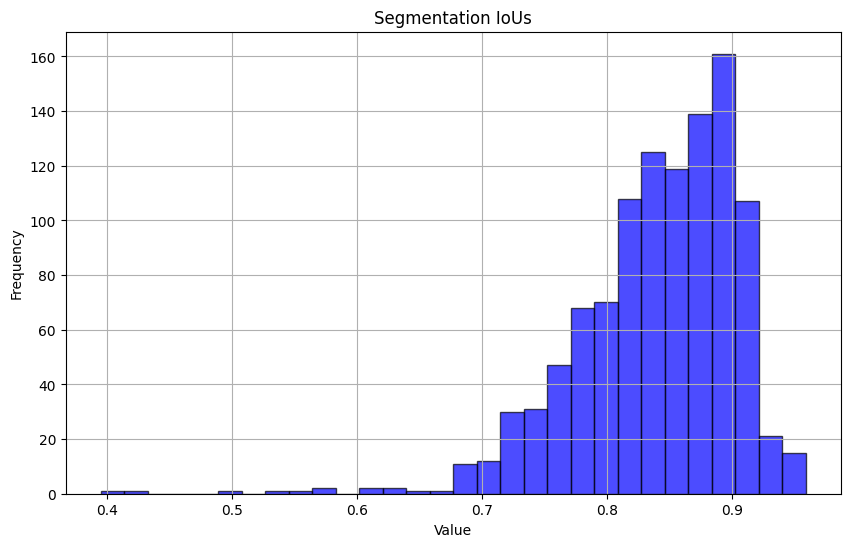

In [33]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(all_ious_flatten, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Segmentation IoUs')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [34]:
all_preds, all_gts, all_ious = [], [], []
for i in range(len(preds)):
    gt_i = np.array([gts[i][j][0].detach().cpu().numpy() for j in range(len(gts[i]))])
    pred_i = np.array([preds[i][j][0].detach().cpu().numpy() for j in range(len(preds[i]))])
    ious_i = np.array([all_iou_scores[i][j][0].detach().cpu().numpy() for j in range(len(all_iou_scores[i]))])
    all_gts.append(gt_i)    
    all_preds.append(pred_i)  
    all_ious.append(ious_i)
    
# all_ious = [iou_score.detach().cpu().numpy() for iou_score in all_iou_scores]
all_gt_classes = [np.array(gt_classes[i], dtype=np.int8) for i in range(len(gt_classes))]
all_pred_classes = [np.array(pred_classes[i], dtype=np.int8) for i in range(len(pred_classes))]

len(all_preds), len(all_gts), len(all_ious), len(all_gt_classes), len(all_pred_classes)

(267, 267, 267, 267, 267)

In [35]:
all_ious[1]

array([0.9076235 , 0.89370775], dtype=float32)

In [36]:
all_preds[1].shape, all_gts[1].shape

((2, 512, 512), (2, 512, 512))

In [37]:
from torch import tensor

preds_per_image = []
gts_per_image = []

for img_i in range(len(all_preds)):
    img_preds_dict = dict(
        masks=tensor(all_preds[img_i], dtype=torch.bool),
        scores=tensor(all_ious[img_i]),
        labels=tensor(all_pred_classes[img_i], dtype=torch.int16),
      )
    img_gts_dict = dict(
        masks=tensor(all_gts[img_i], dtype=torch.bool),
        labels=tensor(all_gt_classes[img_i], dtype=torch.int16),
      )
    preds_per_image.append(img_preds_dict)
    gts_per_image.append(img_gts_dict)
    

In [38]:
preds_per_image[1]['masks'].shape, preds_per_image[1]['scores'].shape, preds_per_image[1]['labels'].shape,

(torch.Size([2, 512, 512]), torch.Size([2]), torch.Size([2]))

In [39]:
preds_per_image

[{'masks': tensor([[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]],
  
          [[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]]]),
  'scores': tensor([0.8946, 0.8480]),
  'labels': tensor([0, 2], dtype=torch.int16)},
 {'masks': tensor([[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
   

In [40]:
gts_per_image

[{'masks': tensor([[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]],
  
          [[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]]]),
  'labels': tensor([0, 2], dtype=torch.int16)},
 {'masks': tensor([[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., Fa

In [66]:
from torch import tensor
from torchmetrics.detection import MeanAveragePrecision

metric = MeanAveragePrecision(
    iou_type = "segm", 
    iou_thresholds = [0.75], 
    max_detection_thresholds=[1, 10, 100],
    class_metrics=True,
    extended_summary=False)

# '''
# extended_summary:
# - ``ious``: a dictionary containing the IoU values for every image/class combination e.g.
#                   ``ious[(0,0)]`` would contain the IoU for image 0 and class 0. Each value is a tensor with shape
#                   ``(n,m)`` where ``n`` is the number of detections and ``m`` is the number of ground truth boxes for
#                   that image/class combination.
#                 - ``precision``: a tensor of shape ``(TxRxKxAxM)`` containing the precision values. Here ``T`` is the
#                   number of IoU thresholds, ``R`` is the number of recall thresholds, ``K`` is the number of classes,
#                   ``A`` is the number of areas and ``M`` is the number of max detections per image.
#                 - ``recall``: a tensor of shape ``(TxKxAxM)`` containing the recall values. Here ``T`` is the number of
#                   IoU thresholds, ``K`` is the number of classes, ``A`` is the number of areas and ``M`` is the number
#                   of max detections per image.
#                 - ``scores``: a tensor of shape ``(TxRxKxAxM)`` containing the confidence scores.  Here ``T`` is the
#                   number of IoU thresholds, ``R`` is the number of recall thresholds, ``K`` is the number of classes,
#                   ``A`` is the number of areas and ``M`` is the number of max detections per image.
# '''

In [67]:
metric.update(preds_per_image, gts_per_image)
from pprint import pprint
pprint(metric.compute())

{'classes': tensor([0, 1, 2], dtype=torch.int32),
 'map': tensor(0.5942),
 'map_50': tensor(-1.),
 'map_75': tensor(0.5942),
 'map_large': tensor(0.4167),
 'map_medium': tensor(0.4922),
 'map_per_class': tensor([0.7669, 0.5456, 0.4701]),
 'map_small': tensor(0.5481),
 'mar_1': tensor(0.4656),
 'mar_10': tensor(0.6804),
 'mar_100': tensor(0.6851),
 'mar_100_per_class': tensor([0.8492, 0.6370, 0.5690]),
 'mar_large': tensor(0.5000),
 'mar_medium': tensor(0.6804),
 'mar_small': tensor(0.6335)}


In [54]:
metric.update(preds_per_image, gts_per_image)
from pprint import pprint
pprint(metric.compute())

{'classes': tensor([0, 1, 2], dtype=torch.int32),
 'map': tensor(0.9471),
 'map_50': tensor(0.9471),
 'map_75': tensor(-1.),
 'map_large': tensor(1.),
 'map_medium': tensor(0.8636),
 'map_per_class': tensor([0.9821, 0.9774, 0.8817]),
 'map_small': tensor(0.9285),
 'mar_1': tensor(0.5383),
 'mar_10': tensor(0.8784),
 'mar_100': tensor(0.8852),
 'mar_100_per_class': tensor([0.9385, 0.9040, 0.8132]),
 'mar_large': tensor(0.8333),
 'mar_medium': tensor(0.7903),
 'mar_small': tensor(0.8507)}


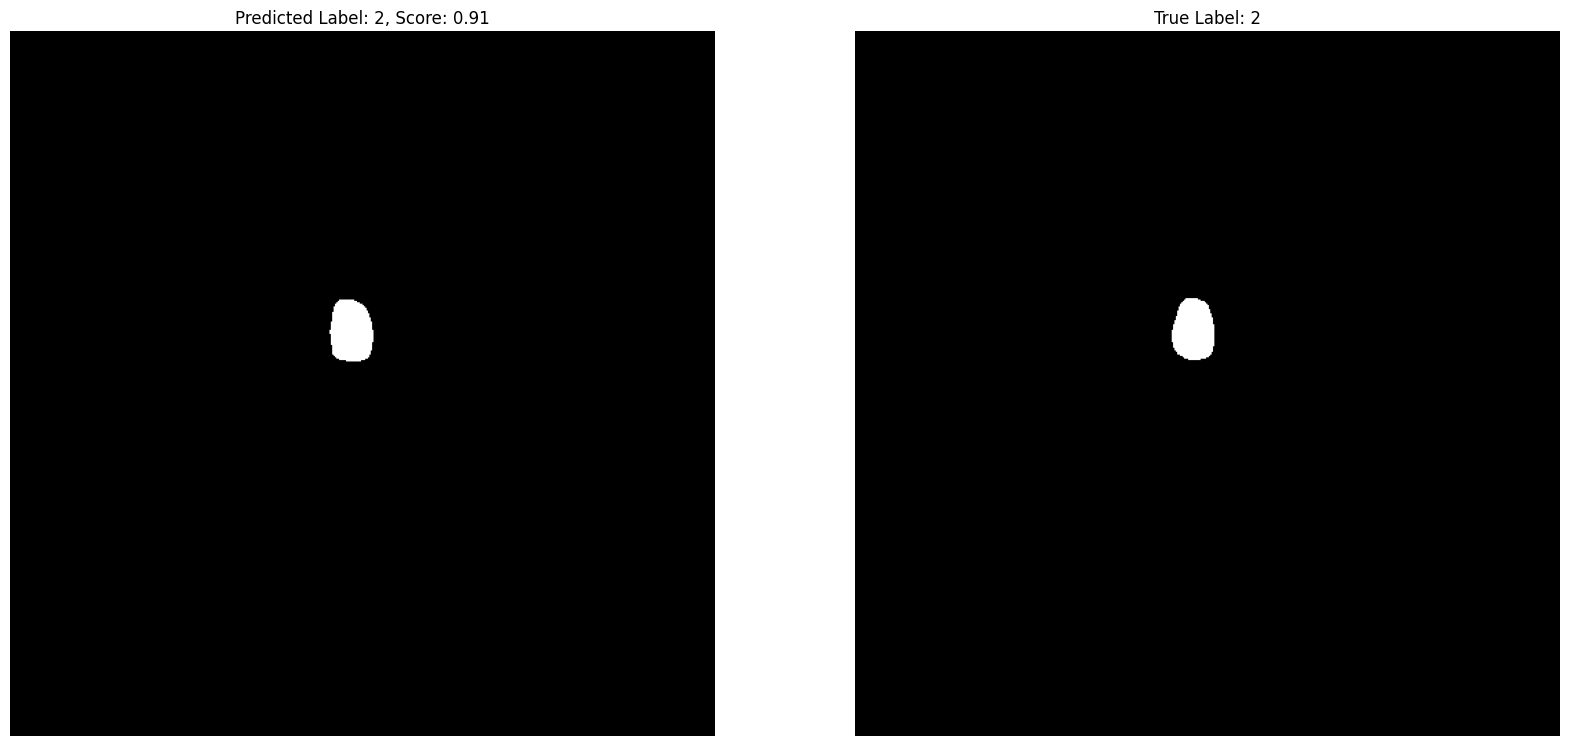

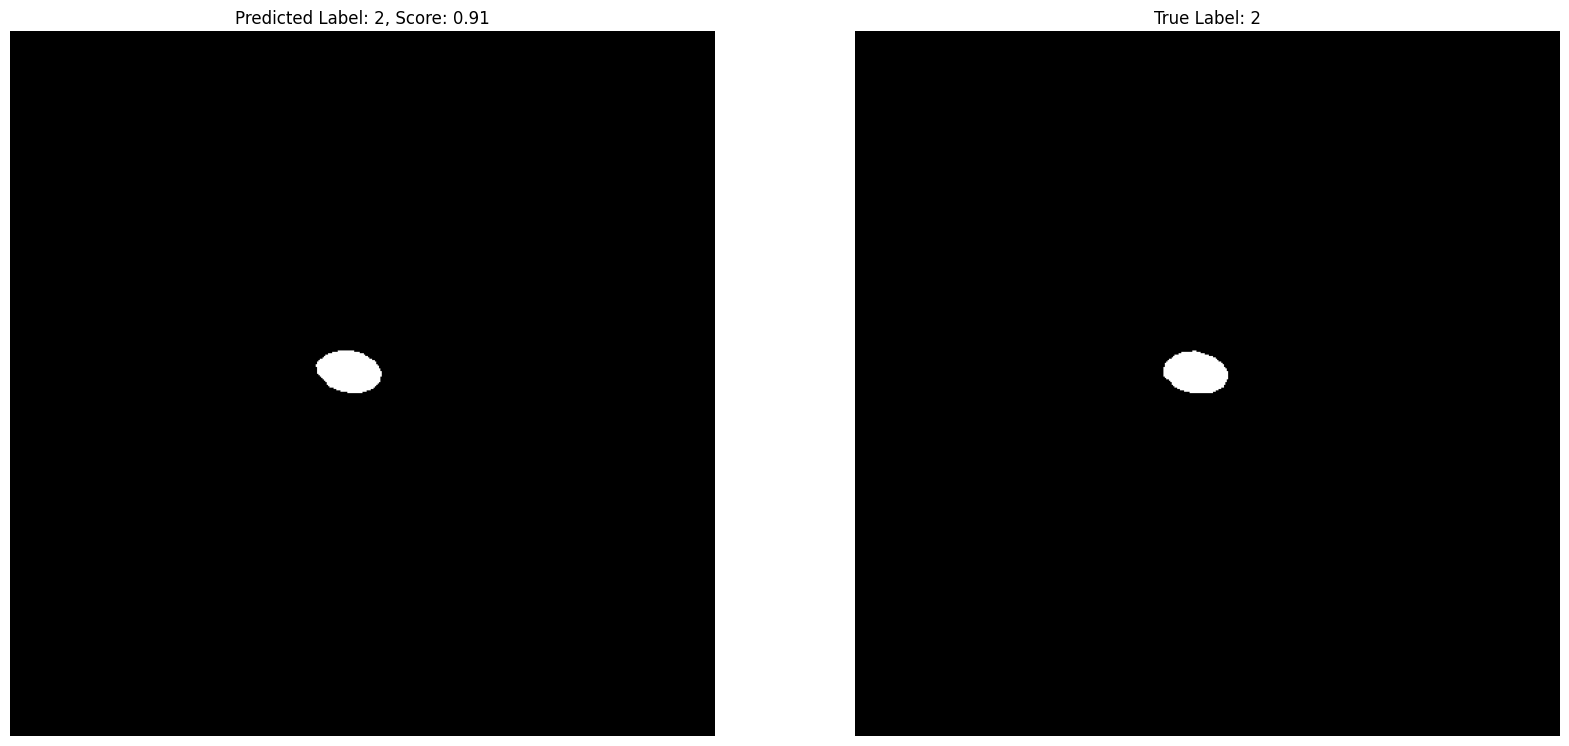

In [49]:
import matplotlib.pyplot as plt
import numpy as np

num_instances = len(preds_per_image)
k=0
for i in range(num_instances):
    for j in range(len(preds_per_image[i]['masks'])):
        k+=1
        if k>10:
            break
        if preds_per_image[i]["scores"][j] >0.9:
            plt.figure(figsize=(20, 10))
            # Plot predicted mask
            plt.subplot(1, 2, 1)
            plt.imshow(preds_per_image[i]['masks'][j].numpy(), cmap='gray')
            plt.title(f'Predicted Label: {preds_per_image[i]["labels"][j].item()}, Score: {preds_per_image[i]["scores"][j].item():.2f}')
            plt.axis('off')
            
            # Plot target (ground truth) mask
            plt.subplot(1, 2, 2)
            plt.imshow(gts_per_image[i]['masks'][j].numpy(), cmap='gray')
            plt.title(f'True Label: {gts_per_image[i]["labels"][j].item()}')
            plt.axis('off')
        
            plt.show()

In [85]:
a = 0
all=0
for i in range(num_instances):
    for j in range(len(preds_per_image[i]['masks'])):
        pred_mask = preds_per_image[i]['masks'][j].numpy()
        pred_label = preds_per_image[i]["labels"][j].item()
        score = preds_per_image[i]["scores"][j].item()
        gt_mask = gts_per_image[i]['masks'][j].numpy()
        gt_label = gts_per_image[i]["labels"][j].item()
        if pred_label == gt_label:
            a+=1
        all+=1
        
a, all, a/all

(821, 869, 0.9447640966628308)

In [66]:
stophere

NameError: name 'stophere' is not defined

In [ ]:
import glob
from roboflow import Roboflow

def export_image_det_to_Roboflow(input_dir, filename, masks, obj_results):
    class_names = obj_results[0].names
    class_labels = obj_results[0].boxes.data[:, -1].int().tolist()
    
    objects = []
    for i in range(len(masks)):
        # masks[i]: [ 1, H, W]
        mask_np = masks[i].detach().cpu().numpy()
        polygon = binary_image_to_polygon(mask_np[0])
        bbox = mask_to_bbox(mask_np)
        if class_names[class_labels[i]] != 'star' and class_names[class_labels[i]] != 'other': # ignore stars and 'other' label
            objects.append({
                'name': class_names[class_labels[i]],
                'bbox': bbox,
                'segmentations': polygon[0]
            })
    if len(objects)>0:
        create_annotation_SAM(filename=filename, width=512, height=512, depth=3, objects=objects) # generating xml file for VOC format
        image_path = input_dir+filename
        annotation_filename = filename.replace(".png", ".xml")
        upload_project.upload(image_path, annotation_filename, overwrite=False)
        os.remove(annotation_filename)
    else:
        print("No objects after label filtering.")

In [ ]:
# Optional Roboflow export in VOC format given filenames
export_to_Roboflow = False
import time

# best_model = mobile_sam_model.cpu()
if export_to_Roboflow:
    # Initialize Roboflow client
    rf = Roboflow(api_key="EBeK30tpU3HW2VGGl0xa")
    upload_project = rf.workspace("orij").project("xmm_om_images_512_sg_sr_cr_only") # error if the project doesn't exist

new_images_dir = '../XMM_OM_dataset/zscaled_512_stretched/'
new_image_files =  os.listdir(new_images_dir)
best_model.eval()
    
with torch.no_grad(): 
    # eg_img = 'S0018141301_M.png'
    for eg_img in new_image_files[701:711]:
    # if True:
            print('Image', new_images_dir+eg_img)
            image = cv2.imread(new_images_dir + eg_img)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            start_time = time.time()
            obj_results = yolov8_pretrained_model.predict(new_images_dir + eg_img, conf=0.2)  
            predictor.set_image(image)
        
            if len(obj_results[0]) == 0:
                print(f"No masks for {eg_img}.")
                plt.imshow(image)
                plt.show()
                plt.close()
                continue
    
            input_boxes1 = obj_results[0].boxes.xyxy
            expand_by = 2.5
            enlarged_bbox = input_boxes1.clone() 
            enlarged_bbox[:, :2] -= expand_by  
            enlarged_bbox[:, 2:] += expand_by  
            input_boxes1 = enlarged_bbox
    
            input_boxes = input_boxes1.cpu().numpy()
            input_boxes = predictor.transform.apply_boxes(input_boxes, predictor.original_size)
            input_boxes = torch.from_numpy(input_boxes).to(device)
            sam_mask, yolo_masks = [], []
            image_embedding=predictor.features
            prompt_embedding=best_model.prompt_encoder.get_dense_pe()
            non_resized_masks = obj_results[0].masks.data.cpu().numpy()
            for i in range(len(non_resized_masks)):
                    yolo_masks.append(cv2.resize(non_resized_masks[i], image.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)) 
        
            for (boxes,) in yolo_predictor_utils.batch_iterator(320, input_boxes): 
                with torch.no_grad():
                    image_embedding=image_embedding[0:boxes.shape[0],:,:,:]
                    prompt_embedding=prompt_embedding[0:boxes.shape[0],:,:,:]
                    sparse_embeddings, dense_embeddings = best_model.prompt_encoder(
                        points=None,
                        boxes=boxes.cpu(),
                        masks=None,)
                    low_res_masks, _ = best_model.mask_decoder(
                        image_embeddings=image_embedding,
                        image_pe=prompt_embedding,
                        sparse_prompt_embeddings=sparse_embeddings,
                        dense_prompt_embeddings=dense_embeddings,
                        multimask_output=False,
                    )
                    low_res_masks=predictor.model.postprocess_masks(low_res_masks, predictor.input_size, predictor.original_size)
                    threshold_masks = torch.sigmoid(low_res_masks - best_model.mask_threshold) 
                    sam_mask_pre = (threshold_masks > 0.5)*1.0
                    sam_mask.append(sam_mask_pre.squeeze(1))
    
                    yolo_masks_tensor = torch.stack([torch.from_numpy(mask).unsqueeze(0) for mask in yolo_masks], dim=0)
                    if export_to_Roboflow:
                        export_image_det_to_Roboflow(new_images_dir, image_name, sam_mask_pre, obj_results)
                    print("Inference time per image:", time.time()-start_time)
                    fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
                    
                    # Plot 1: YOLO Masks
                    axes[0].imshow(image)
                    axes[0].set_title('YOLOv8n predicted Masks')
                    show_masks(yolo_masks, axes[0]) #, random_color=True)
                    
                    # Plot 2: Bounding Boxes
                    image1 = cv2.resize(image, (1024, 1024))
                    for bbox in boxes:
                        x1, y1, x2, y2 = bbox.detach().cpu().numpy()
                        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                        cv2.rectangle(image1, (x1, y1), (x2, y2), (0, 255, 0), 2) 
                    image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
                    axes[1].imshow(image1_rgb)
                    axes[1].set_title('YOLOv8n predicted Bboxes')
                    
                    # Plot 3: SAM Masks
                    sam_masks_numpy = sam_mask[0].detach().cpu().numpy()
                    axes[2].imshow(image)
                    show_masks(sam_masks_numpy, axes[2]) #, random_color=True)
                    axes[2].set_title('MobileSAM predicted masks')
                    plt.tight_layout() 
                    # plt.savefig(f'./plots/combined_plots.png')
                    plt.show()

In [ ]:
mobile_sam_state_dict = best_model.state_dict()

In [ ]:
mobile_sam_state_dict.keys()

In [ ]:
# torch.save(yolov8_pretrained_model.state_dict(), 'yolo_model.bin')
# torch.save(best_model.state_dict(), 'pytorch_model.bin')

In [ ]:
model_v1

In [ ]:
import json

config_dict = {
    "hidden_size": model.hidden_size,
    "num_attention_heads": model.num_attention_heads,
    "num_hidden_layers": model.num_hidden_layers,
}

with open("config.json", "w") as f:
    json.dump(config_dict, f, indent=4)

In [ ]:
# yolov8_pretrained_model.export(format='onnx', imgsz=[512,512])

In [ ]:
# import torch
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# sys.path.append('/workspace/raid/OM_DeepLearning/MobileSAM-fine-tuning/')

# from importlib import reload
# from ft_mobile_sam import sam_model_registry, SamPredictor
# from ft_mobile_sam.utils.onnx import SamOnnxModel

# import onnxruntime
# from onnxruntime.quantization import QuantType
# from onnxruntime.quantization.quantize import quantize_dynamic

# import warnings
# onnx_model_path = None  # Set to use an already exported model, then skip to the next section.

# onnx_model_path = "sam_onnx_example.onnx"

# sam = mobile_sam_model.to('cpu') # the model must be set on CP
# onnx_model = SamOnnxModel(sam, return_single_mask=True)

# dynamic_axes = {
#     "point_coords": {1: "num_points"},
#     "point_labels": {1: "num_points"},
# }

# embed_dim = sam.prompt_encoder.embed_dim
# embed_size = sam.prompt_encoder.image_embedding_size
# mask_input_size = [4 * x for x in embed_size]
# dummy_inputs = {
#     "image_embeddings": torch.randn(1, embed_dim, *embed_size, dtype=torch.float),
#     "point_coords": torch.randint(low=0, high=1024, size=(1, 5, 2), dtype=torch.float),
#     "point_labels": torch.randint(low=0, high=4, size=(1, 5), dtype=torch.float),
#     "mask_input": torch.randn(1, 1, *mask_input_size, dtype=torch.float),
#     "has_mask_input": torch.tensor([1], dtype=torch.float),
#     # "orig_im_size": torch.tensor([1500, 2250], dtype=torch.float),
# }
# output_names = ["masks", "iou_predictions", "low_res_masks"]

# with warnings.catch_warnings():
#     warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
#     warnings.filterwarnings("ignore", category=UserWarning)
#     with open(onnx_model_path, "wb") as f:
#         torch.onnx.export(
#             onnx_model,
#             tuple(dummy_inputs.values()),
#             f,
#             export_params=True,
#             verbose=False,
#             opset_version=16,
#             do_constant_folding=True,
#             input_names=list(dummy_inputs.keys()),
#             output_names=output_names,
#             dynamic_axes=dynamic_axes,
#         )    

In [ ]:
# optional: export to ONNX

# !python scripts/export_onnx_model.py --checkpoint ./weights/mobile_sam.pt --model-type vit_t --output ./mobile_sam.onnx